In [1]:
# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

# Custom Networks
from networks.lenet import LeNet

#from networks.pure_cnn import PureCnn
#from networks.network_in_network import NetworkInNetwork


from networks.resnet import ResNet


# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

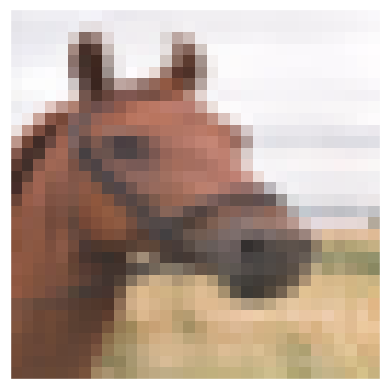

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
image_id = 99 # Image index in the test set
helper.plot_image(x_test[image_id])


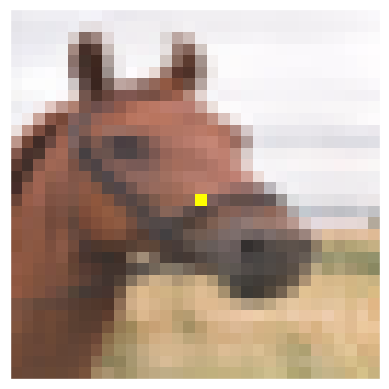

In [3]:
image_id = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = helper.perturb_image(pixel, x_test[image_id])[0]

helper.plot_image(image_perturbed)

In [4]:
resnet = ResNet()
lenet = LeNet()
models = [resnet,lenet]
network_stats, correct_imgs = helper.evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Successfully loaded resnet
Successfully loaded lenet
Evaluating  resnet ...
Evaluating  lenet ...


,name,accuracy,param_count
0,resnet,0.9173,470218
1,lenet,0.7522,71919


In [5]:
def predict_classes(xs, img, target_class, model, minimize=True):
  # Perturb the image with the given pixel(s) x and get the prediction of the model
  imgs_perturbed = helper.perturb_image(xs, img)
  predictions = model.predict(imgs_perturbed)[:,target_class]
  # This function should always be minimized, so return its complement if needed
  return predictions if minimize else 1 - predictions

Confidence in true class ship is 0.9999894
Prior confidence was 0.9999069


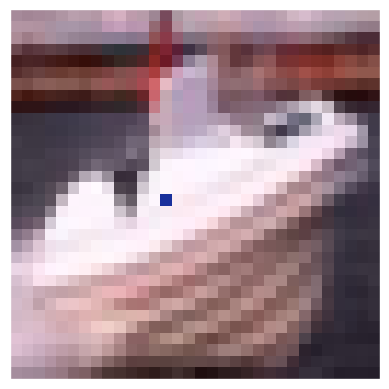

In [6]:
image_id = 108
pixel = np.array([16, 13,  25, 48, 156])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
confidence = predict_classes(pixel, x_test[image_id], true_class, model)[0]

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)
helper.plot_image(helper.perturb_image(pixel, x_test[image_id])[0])

In [7]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
  # Perturb the image with the given pixel(s) and get the prediction of the model
  attack_image = helper.perturb_image(x, img)

  confidence = model.predict(attack_image)[0]
  predicted_class = np.argmax(confidence)
  
  # If the prediction is what we want (misclassification or 
  # targeted classification), return True
  if verbose:
      print('Confidence:', confidence[target_class])
  if ((targeted_attack and predicted_class == target_class) or
      (not targeted_attack and predicted_class != target_class)):
      return True

In [8]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    target_class = y_test[img_id, 0]
    
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)]
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class, 
                              model, False, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = helper.perturb_image(attack_result.x, x_test[img_id])[0]
    prior_probs = model.predict_one(x_test[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]

In [9]:
def attack_all(model=lenet, maxiter=75, popsize=400, verbose=False):
    results = []

    model_results = []
    valid_imgs = correct_imgs[correct_imgs.name == model.name].img
    
    img_samples = np.random.choice(valid_imgs, 5, replace=False)
    #img_samples = np.random.choice(valid_imgs, 1000, replace=False)
    for i, img_id in enumerate(img_samples):
        print('\n', model.name, '- image', img_id, '-', i+1, '/', len(img_samples))
        
        result = attack(img_id, model, None, 1, 
                        maxiter=maxiter, popsize=popsize, 
                        verbose=verbose)
        model_results.append(result)
                
    results += model_results
    return results


 lenet - image 7972 - 1 / 5


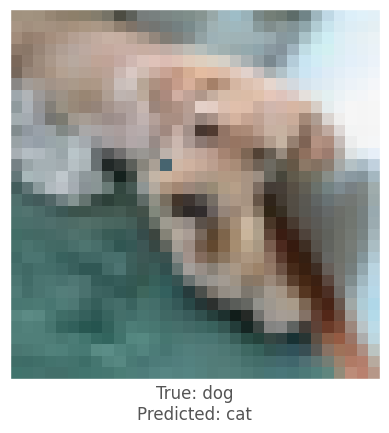


 lenet - image 1767 - 2 / 5


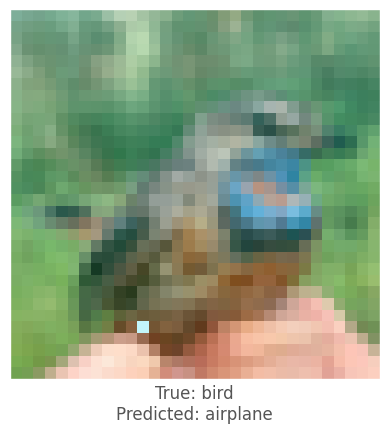


 lenet - image 8790 - 3 / 5


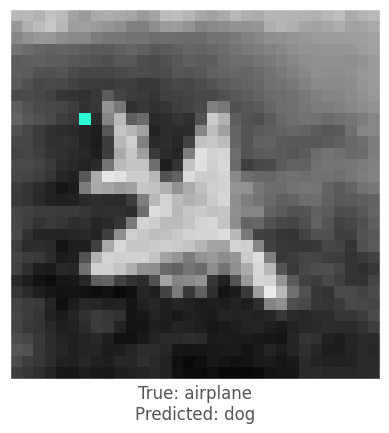


 lenet - image 4636 - 4 / 5


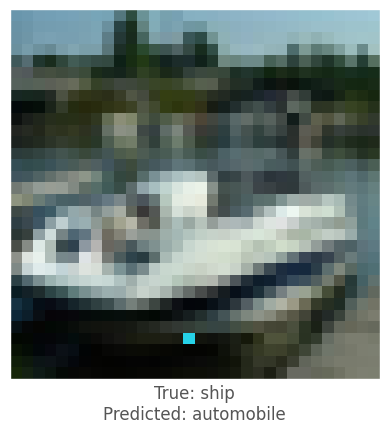


 lenet - image 3880 - 5 / 5


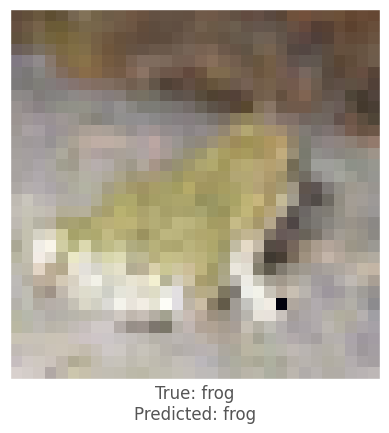

In [10]:
untargeted = attack_all(model=lenet)

In [11]:
untargeted, targeted = helper.load_results()
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation']
untargeted_results = pd.DataFrame(untargeted, columns=columns)

In [12]:
helper.attack_stats(untargeted_results, [lenet], network_stats)

,model,accuracy,pixels,attack_success_rate



 lenet - image 635 - 1 / 5


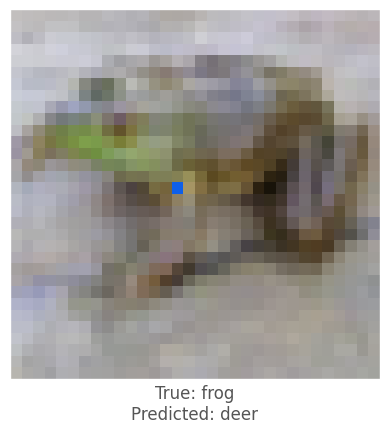


 lenet - image 4196 - 2 / 5


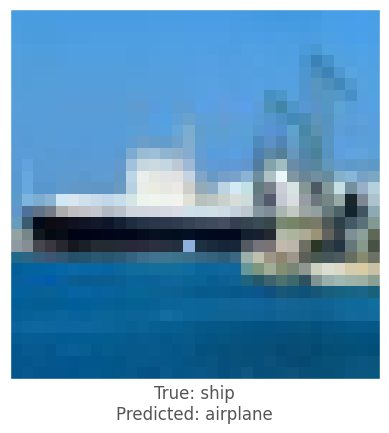


 lenet - image 7700 - 3 / 5


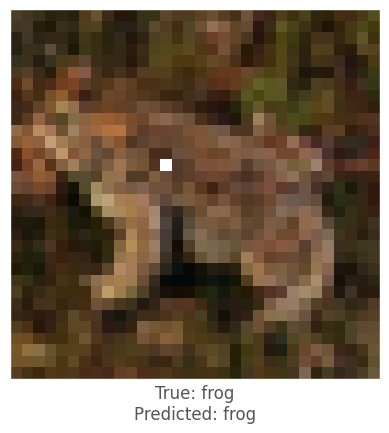


 lenet - image 9965 - 4 / 5


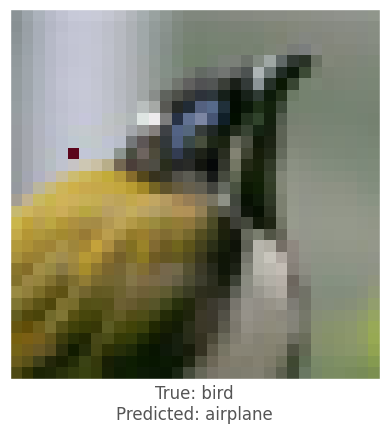


 lenet - image 414 - 5 / 5


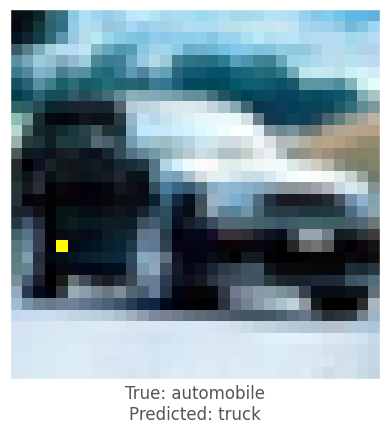

In [13]:
untargeted = attack_all(model=lenet)

In [14]:
untargeted, targeted = helper.load_results()
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation']
untargeted_results = pd.DataFrame(untargeted, columns=columns)

In [15]:
helper.attack_stats(untargeted_results, [lenet], network_stats)

,model,accuracy,pixels,attack_success_rate
